In [1]:
%matplotlib inline
import csv
import pickle
import gensim
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from gensim.models.callbacks import CallbackAny2Vec

import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool, CustomJS
from bokeh.plotting import figure, show, output_notebook
from bokeh.embed import components, file_html
from bokeh.resources import CDN, Resources
from bokeh.models.widgets import TextInput
from bokeh.layouts import column
from bokeh.core.properties import Instance
from bokeh.util.compiler import TypeScript
from bokeh.models.widgets.inputs import InputWidget, String
from bokeh.models.callbacks import Callback

In [2]:
class logger(CallbackAny2Vec):
    None
    
embedding_model = gensim.models.Word2Vec.load('word2vec.model')
print(embedding_model)
embedding = embedding_model.wv.syn0

Word2Vec(vocab=452130, size=100, alpha=0.025)


/home/teticio/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  


In [3]:
print('Read in tracks...')
tracks = {}
with open('popular_tracks.csv', "r", encoding='utf-8') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=';')
    for row in spamreader:
        columns = str(row)[2:-2].split(';')
        tracks[columns[0]] = [columns[1] + ' - ' +
                              columns[2], columns[3]] # title - artist, url
print(f'Number of tracks: {len(tracks)}')

Read in tracks...
Number of tracks: 452130


In [4]:
mp3tovecs = pickle.load(open('../spotifytovec.p', 'rb'))
w2c = []
for item in mp3tovecs:
    if item in tracks and tracks[item][1] != '':
        w2c.append((item, tracks[item][0], tracks[item][1], embedding_model.wv.vocab[item].count))
w2c = sorted(w2c, key=lambda x: x[3], reverse=True)
len(w2c)

320949

In [5]:
track_names = dict([(i, (_[1], _[2])) for i, _ in enumerate(w2c)])
vectors = np.concatenate([np.expand_dims(embedding[embedding_model.wv.vocab[_[0]].index], axis=0) for _ in w2c])

In [6]:
# custom widget that only has callback when the focus changes

output_notebook()

TS_CODE = """
import {TextInput, TextInputView} from "models/widgets/text_input"

import * as p from "core/properties"

export class MyTextInputView extends TextInputView {
  model: MyTextInput

  change_input(): void {
    this.model.value = this.input_el.value
    super.change_input()
  }
  
  change_input_oninput(): void {
    this.model.value_input = this.input_el.value
  }
}

export namespace MyTextInput {
  export type Attrs = p.AttrsOf<Props>

  export type Props = TextInput.Props
}

export interface MyTextInput extends MyTextInput.Attrs {}

export class MyTextInput extends TextInput {
  properties: MyTextInput.Props

  constructor(attrs?: Partial<MyTextInput.Attrs>) {
    super(attrs)
  }

  static init_MyTextInput(): void {
    this.prototype.default_view = MyTextInputView
  }
}
"""


class MyTextInput(InputWidget):
    ''' Single-line input widget.
    '''

    __implementation__ = TypeScript(TS_CODE)
    
    value = String(default="", help="""
    Initial or entered text value.
    Change events are triggered whenever <enter> is pressed.
    """)
    
    callback = Instance(Callback, help="""
    A callback to run in the browser whenever the current Slider value changes.
    """)

Loading BokehJS ...

In [7]:
tooltips = """
    <audio class="preview">
        <source src="@url" type="audio/mp3">
    </audio>
    <div style="font-family: Calibri; font-size: 12px;">
        <span class="play" style="visibility: hidden;">▶️</span>@track
    </div>
"""
code = """
    function next_track(previews, plays, i) {
        if (i > 0) {
            plays[i-1].style.visibility = "hidden";
        }
        if (previews[i]) {
            previews[i].onended = function() {
                next_track(previews, plays, i+1);
            }
            plays[i].style.visibility = "visible";
            previews[i].play();
        }
    }
    next_track(document.getElementsByClassName("preview"), document.getElementsByClassName("play"), 0);
"""


def plot_tsne(embedding_matrix, index_to_word, num_words = None, title = 't-SNE',
              random_state=None, tsne_df=None, perplexity=30):
    matrix = embedding_matrix
    if num_words is not None:
        matrix = matrix[:num_words,:]
    info = [index_to_word.get(_, ("<UNK>", "")) for _ in range(matrix.shape[0])]
    tracks = [_[0] for _ in info]
    urls = [_[1] for _ in info]
    
    # defining the chart
    output_notebook(Resources(mode="cdn", components=["bokeh", "bokeh-gl"]))
    fig = bp.figure(output_backend="webgl", sizing_mode='stretch_both', title=title,
                    tools="pan,wheel_zoom,box_zoom,reset,undo,hover",
                    x_axis_type=None, y_axis_type=None)

    # dimensionality reduction. converting the vectors to 2d vectors
    tsne_model = TSNE(n_components=2, verbose=2, random_state=random_state, perplexity=perplexity)
    tsne_w2v = tsne_model.fit_transform(matrix)

    # putting everything in a dataframe
    tsne_df = pd.DataFrame(tsne_w2v, columns=['x', 'y'])
    tsne_df['track'] = tracks
    tsne_df['url'] = urls
    tsne_df['color'] = 'blue'

    # plotting. the corresponding word appears when you hover on the data point.
    fig.scatter(x='x', y='y', fill_color='color', line_color='color', source=tsne_df, line_alpha=0.5, fill_alpha=0.5)
    hover = fig.select(dict(type=HoverTool))
    hover.tooltips = tooltips
    hover.callback = CustomJS(args={}, code=code)
    return fig, tsne_df

In [ ]:
fig, tsne_df = plot_tsne(vectors, track_names, random_state = 616906225, title = f'Track2Vec (creativity = 0) t-SNE projection from 100 dimensions into 2 of {len(track_names):,} Spotify tracks')

Loading BokehJS ...

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 320949 samples in 1.770s...


In [ ]:
output_notebook()
textinput = MyTextInput(value="", title="Find tracks:")
textinput.callback = CustomJS(args=dict(source=fig.renderers[0].data_source), code="""
    for (i = 0; i < source.data['track'].length; i++) {
        if (this.value.trim() == '') {
            found = false;
        } else {
            found = true;
            text = this.value.split(' ');
            for (j = 0; j < text.length; j++) {
                if (!source.data['track'][i].toLowerCase().includes(text[j].toLowerCase())) {
                    found = false;
                    break;
                }
            }
        }
        if (found) {
            source.data['color'][i] = 'red';
        } else {        
            source.data['color'][i] = 'blue';
        }
    }
    source.change.emit();
""")
layout = column(fig, textinput, sizing_mode='scale_width')
#show(layout)

In [ ]:
script, div = components(layout)

In [ ]:
html = """
<!DOCTYPE html>
<html lang="en">
    <head>
        <meta charset="utf-8">
        <title>Track2Vec t-SNE</title>
        <script src="https://cdn.bokeh.org/bokeh/release/bokeh-1.4.0.min.js"></script>
        <script src="https://cdn.pydata.org/bokeh/release/bokeh-gl-1.4.0.min.js"></script>
        <script src="https://cdn.bokeh.org/bokeh/release/bokeh-widgets-1.4.0.min.js"></script>
        <script src="https://cdn.bokeh.org/bokeh/release/bokeh-tables-1.4.0.min.js"></script>
""" + script + """
    </head>
    <body>
""" + div + """
    </body>
</html>
"""

In [ ]:
with open('tracktovec.html', 'wt') as file:
    file.write(html)

In [ ]:
img = mpimg.imread('spectrograms/train/000JCyEkMFumqCZQJAORiQ.png')

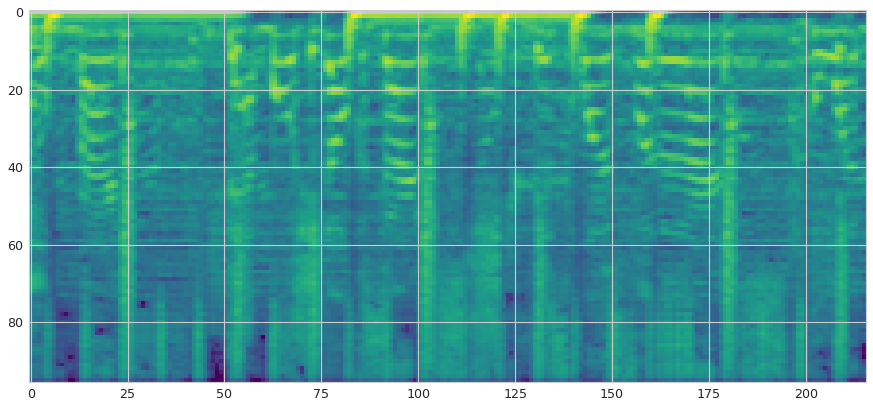

In [14]:
plt.figure(figsize = (15, 30))
plt.imshow(img)

In [18]:
track_names = dict([(i, (_[1], _[2])) for i, _ in enumerate(w2c)])
vectors = np.concatenate([np.expand_dims(mp3tovecs[_[0]], axis=0) for _ in w2c])

In [19]:
fig, tsne_df = plot_tsne(vectors, track_names, random_state = 615906225, title = f'Mp3ToVec (creativity = 1) t-SNE projection from 100 dimensions into 2 of {len(track_names):,} Spotify tracks')

Loading BokehJS ...

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 320949 samples in 1.795s...
[t-SNE] Computed neighbors for 320949 samples in 2922.488s...
[t-SNE] Computed conditional probabilities for sample 1000 / 320949
[t-SNE] Computed conditional probabilities for sample 2000 / 320949
[t-SNE] Computed conditional probabilities for sample 3000 / 320949
[t-SNE] Computed conditional probabilities for sample 4000 / 320949
[t-SNE] Computed conditional probabilities for sample 5000 / 320949
[t-SNE] Computed conditional probabilities for sample 6000 / 320949
[t-SNE] Computed conditional probabilities for sample 7000 / 320949
[t-SNE] Computed conditional probabilities for sample 8000 / 320949
[t-SNE] Computed conditional probabilities for sample 9000 / 320949
[t-SNE] Computed conditional probabilities for sample 10000 / 320949
[t-SNE] Computed conditional probabilities for sample 11000 / 320949
[t-SNE] Computed conditional probabilities for sample 12000 / 320949
[t-SNE] Computed conditional prob

[t-SNE] Computed conditional probabilities for sample 120000 / 320949
[t-SNE] Computed conditional probabilities for sample 121000 / 320949
[t-SNE] Computed conditional probabilities for sample 122000 / 320949
[t-SNE] Computed conditional probabilities for sample 123000 / 320949
[t-SNE] Computed conditional probabilities for sample 124000 / 320949
[t-SNE] Computed conditional probabilities for sample 125000 / 320949
[t-SNE] Computed conditional probabilities for sample 126000 / 320949
[t-SNE] Computed conditional probabilities for sample 127000 / 320949
[t-SNE] Computed conditional probabilities for sample 128000 / 320949
[t-SNE] Computed conditional probabilities for sample 129000 / 320949
[t-SNE] Computed conditional probabilities for sample 130000 / 320949
[t-SNE] Computed conditional probabilities for sample 131000 / 320949
[t-SNE] Computed conditional probabilities for sample 132000 / 320949
[t-SNE] Computed conditional probabilities for sample 133000 / 320949
[t-SNE] Computed con

[t-SNE] Computed conditional probabilities for sample 250000 / 320949
[t-SNE] Computed conditional probabilities for sample 251000 / 320949
[t-SNE] Computed conditional probabilities for sample 252000 / 320949
[t-SNE] Computed conditional probabilities for sample 253000 / 320949
[t-SNE] Computed conditional probabilities for sample 254000 / 320949
[t-SNE] Computed conditional probabilities for sample 255000 / 320949
[t-SNE] Computed conditional probabilities for sample 256000 / 320949
[t-SNE] Computed conditional probabilities for sample 257000 / 320949
[t-SNE] Computed conditional probabilities for sample 258000 / 320949
[t-SNE] Computed conditional probabilities for sample 259000 / 320949
[t-SNE] Computed conditional probabilities for sample 260000 / 320949
[t-SNE] Computed conditional probabilities for sample 261000 / 320949
[t-SNE] Computed conditional probabilities for sample 262000 / 320949
[t-SNE] Computed conditional probabilities for sample 263000 / 320949
[t-SNE] Computed con

In [ ]:
output_notebook()
textinput = MyTextInput(value="", title="Find tracks:")
textinput.callback = CustomJS(args=dict(source=fig.renderers[0].data_source), code="""
    for (i = 0; i < source.data['track'].length; i++) {
        if (this.value.trim() == '') {
            found = false;
        } else {
            found = true;
            text = this.value.split(' ');
            for (j = 0; j < text.length; j++) {
                if (!source.data['track'][i].toLowerCase().includes(text[j].toLowerCase())) {
                    found = false;
                    break;
                }
            }
        }
        if (found) {
            source.data['color'][i] = 'red';
        } else {        
            source.data['color'][i] = 'blue';
        }
    }
    source.change.emit();
""")
layout = column(fig, textinput, sizing_mode='scale_width')
#show(layout)

In [26]:
script, div = components(layout)

In [27]:
html = """
<!DOCTYPE html>
<html lang="en">
    <head>
        <meta charset="utf-8">
        <title>Mp3ToVec t-SNE</title>
        <script src="https://cdn.bokeh.org/bokeh/release/bokeh-1.4.0.min.js"></script>
        <script src="https://cdn.pydata.org/bokeh/release/bokeh-gl-1.4.0.min.js"></script>
        <script src="https://cdn.bokeh.org/bokeh/release/bokeh-widgets-1.4.0.min.js"></script>
        <script src="https://cdn.bokeh.org/bokeh/release/bokeh-tables-1.4.0.min.js"></script>
""" + script + """
    </head>
    <body>
""" + div + """
    </body>
</html>
"""

In [28]:
with open('mp3tovec.html', 'wt') as file:
    file.write(html)

In [23]:
tsne_df.head()

,x,y,track,url,color
0,-16.447363,-11.248156,XXXTENTACION - SAD!,https://p.scdn.co/mp3-preview/5b5a9c4dba2f360f...,blue
1,3.420688,-17.585630,Post Malone - Better Now,https://p.scdn.co/mp3-preview/607d2a850975b41f...,blue
2,-14.367495,-22.391979,Tyga - Taste (feat. Offset),https://p.scdn.co/mp3-preview/93d60b97736368a2...,blue
3,-0.618206,-25.103191,XXXTENTACION - Jocelyn Flores,https://p.scdn.co/mp3-preview/9fd5ccc86f318c30...,blue
4,16.719732,17.099169,XXXTENTACION - Moonlight,https://p.scdn.co/mp3-preview/91e4395aff0c73f0...,blue


In [24]:
tsne_df.describe()

,x,y
count,320949.000000,320949.000000
mean,0.014532,0.037372
std,15.333205,15.633592
min,-35.816612,-33.836021
25%,-12.221579,-11.937753
50%,0.295595,-0.423036
75%,11.612016,11.949335
max,34.732643,35.437080


In [25]:
tsne_df[tsne_df['track'].str.contains('Monolink')]

,x,y,track,url,color
30156,-4.227654,-19.825525,Monolink - The End,https://p.scdn.co/mp3-preview/dd5ab8ba927e095d...,blue
49313,-4.849422,-22.431459,Monolink - New Morning,https://p.scdn.co/mp3-preview/a5864f2fcf9c7a73...,blue
62556,-4.591578,-21.863840,Monolink - Burning Sun - Radio Edit,https://p.scdn.co/mp3-preview/84761ff9856197bf...,blue
67614,-6.450843,-19.522890,Monolink - Sirens,https://p.scdn.co/mp3-preview/cd3c55efdc642fe4...,blue
76061,-3.994507,-23.044682,Monolink - Swallow - Tale Of Us Remix,https://p.scdn.co/mp3-preview/b6df8b23116e6808...,blue
155077,-4.926986,-24.563253,Monolink - Sirens - Patrice Bäumel Remix,https://p.scdn.co/mp3-preview/e8f5f189928fe69d...,blue
179099,-4.546000,-21.930794,Monolink - Burning Sun - Original,https://p.scdn.co/mp3-preview/0863c765e4126b64...,blue
203557,-4.751231,-22.341562,Monolink - Black Day,https://p.scdn.co/mp3-preview/1691f52968ba4ada...,blue
237815,-6.316751,-19.629179,Monolink - Sirens - Extended Version,https://p.scdn.co/mp3-preview/3fc28b8dcda7ce9f...,blue
248410,-6.278562,-24.806055,Monolink - Burning Sun - Be Svendsen Remix,https://p.scdn.co/mp3-preview/24aa2ea40749c989...,blue
